Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW7.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW7.ipynb`
- `model_config.yaml`
- `train_config.yaml`

In [1]:
"""
DO NOT MODIFY THIS CELL OR ADD ANY ADDITIONAL IMPORTS ANYWHERE ELSE IN THIS NOTEBOOK!
"""
from typing import Sequence, Tuple, Union
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.autolayout': True})

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.utils.data import DataLoader

from HW7_utils import AirfoilDataset, VAE_Tracker, plot_airfoils, save_yaml, zip_files

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'

print(f'Device is {Device}')

Device is cpu


# Fundamentals of VAEs (Variational Autoencoders) (30)

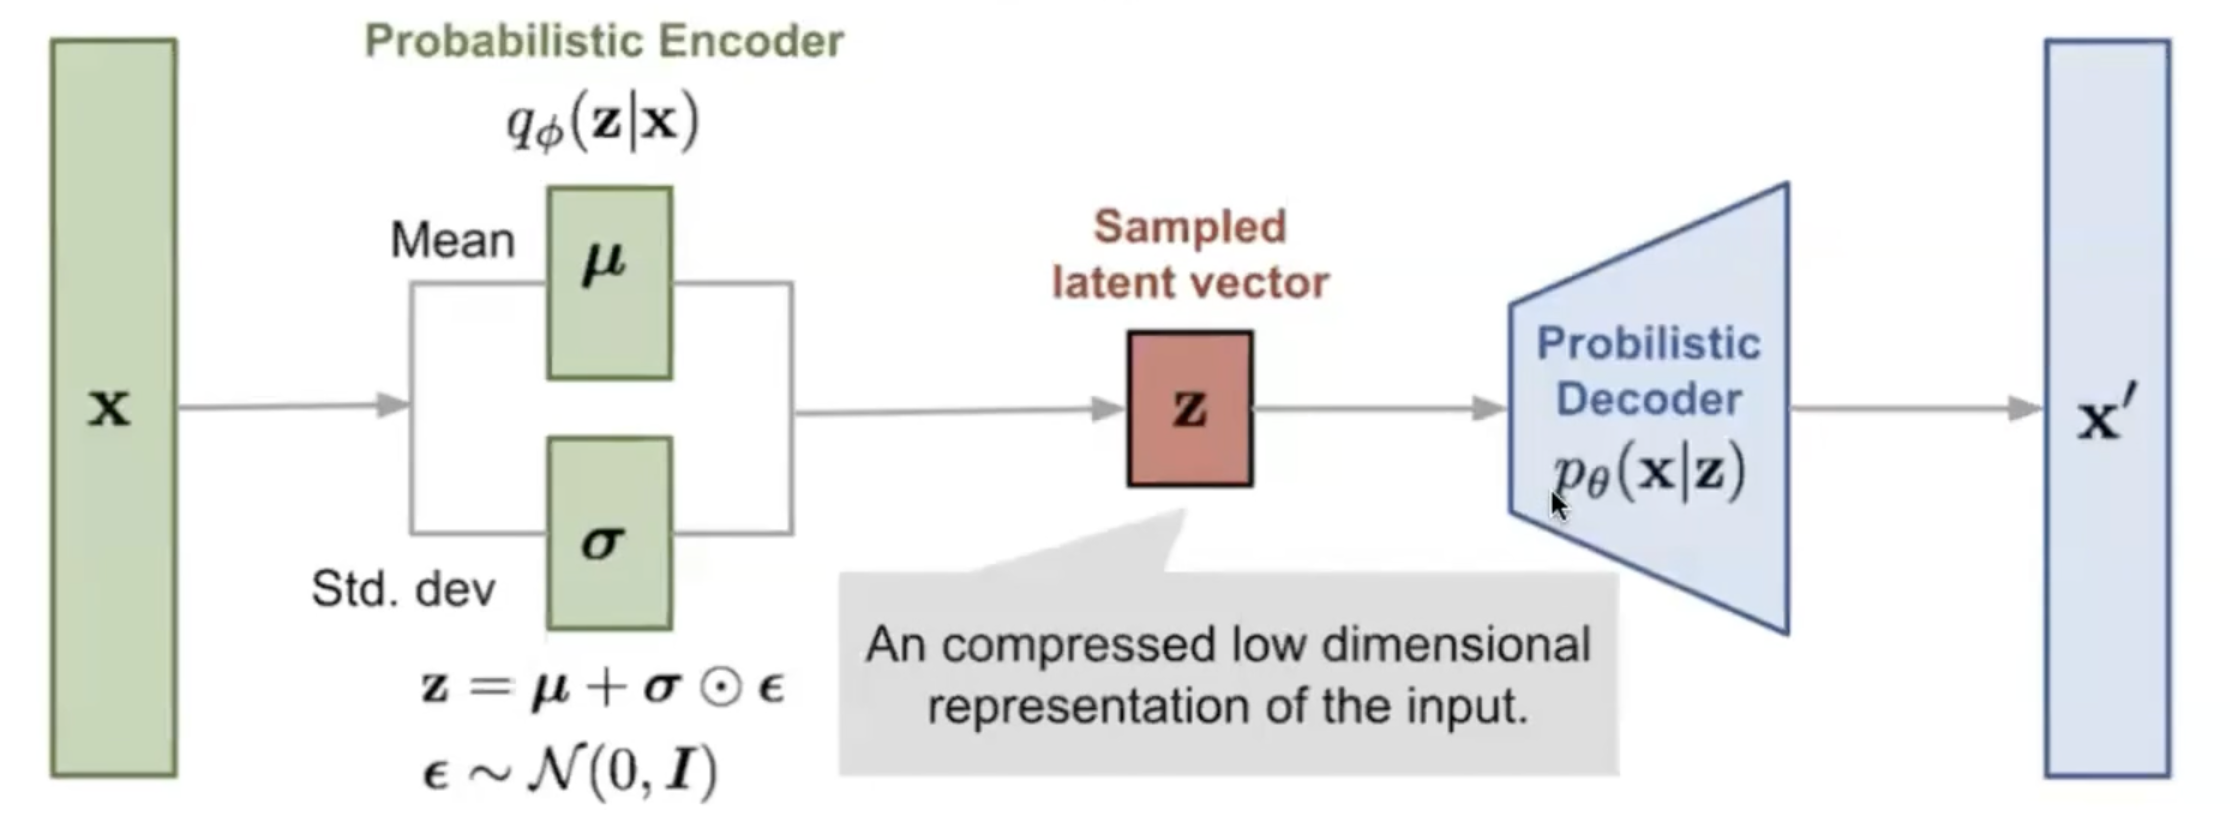

## The Encoder

Unlike a plain autoencoder, the encoder of a VAE does not give as output just a single encoding $z$, but a probability distribution. More specifically, if the input is $x$ and the latent code is $z$, the encoder now represents $prob(z|x)$, which is the __conditional probability distribution__ of $z$ given the observed input $x$. In the typical VAE, this distribution is assumed to be a normal distribution with learnable mean and variance. In this case, the implementation of the encoder gives as output $\mu_\phi(x)$ and $\sigma^2_\phi(x)$, where $\phi$ represents the learnable parameters of the encoder. The actual output of the encoder is then the following distribution:
$$
q_\phi(z|x)=N\Big(\mu_\phi(x), \sigma_\phi^2(x)\Big)
$$
$x$ can be any kind of data like 1D (vector), 2D(images), or 3D(volumes or videos) data. $z$ can also be of any shape, but is usually a vector of a certain size. For convenience, it is assumed that the different elements of the latent vector are independent random variables, each with its own mean and variance. This makes the covariance matrix diagonal, and the calculations will be element-wise during implementation.


## The Decoder

In theory, the decoder is also a probabilistic function that maps a latent vector $z$ to the __conditional probability distribution__ of the data samples $x$ that correspond to that $z$, denoted as $p(x|z)$. However, this is not the common case in practice as the data is usually high-dimensional and modeling a probability distribution for it is not practically plausible. Therefore, the decoder is usually implemented as a deterministic model that takes as input a latent variable $z$ and gives as output a generated sample $\hat{x}$. You can also think of this as the mean of $p(x|z)$, not considering the variance.

During Training, the encoder and decoder are trained end-to-end, and the input to the decoder is sampled from the output of the encoder $q(z|x)$, and the output of the decoder is expected to be similar to the original input data.

During generation, We want to generate new samples using the trained decoder. However, we want to be able to assume that the learned encoding of the VAE follows a desired distribution, so we do not have to analyze the learned latent space after training to find out what range in the latent space will lead to good generated samples. 

Let's assume we want the learned $z$ to follow a distribution $p(z)$ (called the prior), which is usually a standard normal distribution $N(0, I)$. The mechanism that makes the model learn $z$ to try to follow that distribution, is to add a new term to the loss funtion, which penalizes the encoded  $q(z|x)$ that are too far from the prior distribution $p(z)$. Let's take a closer look on how that works.

## The Loss

The main purpose of a VAE is to generate new data by decoding arbitrary latent vectors sampled from a predefined distribution $p(z)$. Therefore, it has to learn to encode input data to the desired distribution as well.

If the distribution of the latent vector $z$ follows the distribution $p(z)$, the conditional distribution of $z$ given a certain input $x$ is expected to be close to $p(z)$ but more narrowed down or zoomed. This is true for any two dependent random variables (here $x$ and $z$). Therefore, it is reasonable to include an additional term in the loss function that penalizes the distance of $q_\phi(z|x)$ from $p(z)$.

The final loss function of a VAE is written as:
$$
L_{VAE} = L_{rec} + \beta L_{prior}
$$
where $L_{rec}$ is the reconstruction loss (the loss for plain autoencoders), $L_{prior}$ penalizes the distance of the conditional distribution $q_\phi(z|x)$ from the prior distribution $p(z)$, and $\beta$ balances the contribution of this term to the total loss. With this loss function, the encoder is no longer free to encode the data to any arbitrary range of latent values. Those values have to be reasonably close to the prior distribution $p(z)$ so we can assume the eventual distribution of the data in the learned latent space somewhat resembles the presumed distribution $p(z)$.

The most common function used to calculate the distance between two probability distributions is the __Kullback–Leibler (KL) divergence__. For two arbitrary distributions, it is defined as follows:
$$
D_{KL}\Big(P(x)||Q(x)\Big) = \mathbb{E}_{x\sim P(x)}\Bigg[-log \bigg(\dfrac{Q(x)}{P(x)}\bigg) \Bigg] = \int -log \bigg(\dfrac{Q(x)}{P(x)}\bigg) P(x) dx
$$
Where $\mathbb{E}$ is the sybmol for __expected value__. The theoretical background and derivation of the KL-divergence comes from maximizing the likelihood of the input data $p(x|z)$ based on the assumed prior $p(z)$ and calculated posterior $q_\phi(z|x)$ from the encoder. You can look it up if you are interested.

For $L_{prior}$ in the VAE loss, the random variable is the latent vector $z$, and we replace $P(x)$ with $q_\phi(z|x)$ and replace $Q(x)$ with $p(z)$:
$$
D_{KL}\Big(q_\phi(z|x)||p(z)\Big) = \mathbb{E}_{z\sim q(z|x)} \Bigg[ -log \bigg(\dfrac{p(z)}{q_\phi(z|x)}\bigg) \Bigg] = \int -log \bigg(\dfrac{p(z)}{q_\phi(z|x)}\bigg) q_\phi(z|x) dz
$$

## __QUESTION__ (15)
If $z$ is a scalar (1 dimension), calculate $D_{KL}\Big(q(z|x)||p(z)\Big)$ in terms of $\mu$ and $\sigma$ (you can drop $(x)$ from $\mu(x), \sigma(x)$ for convenience in your derivation). Write your answer as latex code lines, where each line is between two lines of $$. Take a look at the code for the markdown cells with equations to understand how it works. You can also write your solution on paper, and send a picture of it to ChatGPT and ask it to give you the latex code for it.

Here's what you need to get started:
$$
q(z|x) = N(\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\dfrac{(z-\mu)^2}{2\sigma^2}}
$$
$$
p(z) = N(0, 1) = \frac{1}{\sqrt{2\pi}} e^{-\dfrac{z^2}{2}}
$$
If $z\sim N(\mu, \sigma^2)$, then:
$$
\mathbb{E}[z] = \mu \quad\quad \mathbb{E}[z^2] = \mu^2 + \sigma^2
$$
Also, remember that $\mathbb{E}$ is a linear operator, meaning:
$$
\mathbb{E}[ax+b] = a\mathbb{E}[x] + b
$$
where $x$ is a random variable, and $a, b$ are independent from $x$.

For convenience, no need to write the distribution under $\mathbb{E}$. It is implied that the expected value is being taken with respect to $z\sim N(\mu, \sigma^2)$. You __DO NOT__ need to calculate any integrals here. Everything is represented as expected values, and calculated using the hints above. You can check your final answer by implementing the function and submitting your code to the autograder. 5 points is given if the final answer is correct, and 10 points is for your derivation.

__RESPONSE__:
$$
D_{KL} = \mathbb{E} \Bigg[-log \bigg(\dfrac{p(z)}{q(z|x)}\bigg) \Bigg] = \frac{1}{2}\bigl(\mu^2 + \sigma^2 - 1 - \ln(\sigma^2)\bigr)
$$ 

And even better to be simplified just in case for points:
$$
D_{KL}\bigl(q(z)\|p(z)\bigr) 
= - \ln(\sigma) \;+\; \frac{\sigma^2 + \mu^2 - 1}{2}
$$

In [ ]:
# AUTOGRADED (5)

def D_KL(
        mu: torch.FloatTensor, # shape (batch_size, latent_size),
        logvar: torch.FloatTensor, # shape (batch_size, latent_size),
        ) -> torch.FloatTensor: # shape ()
    """
    Compute the KL divergence that you derived earlier, elementwise.
    Then, average over the batch dimension and latent dimension.

    mu: mean of q(z|x)
    logvar: Logarithm of variance of q(z|x).
    """
    # Elementwise KL
    kl = 0.5 * (mu**2 + torch.exp(logvar) - 1.0 - logvar)

    # Average over all dimensions (batch and latent size)
    return kl.mean()

In [ ]:
"""
TEST D_KL
"""
def test_d_kl(seed: int = 0):
    torch.manual_seed(seed)
    mu = torch.randn(10, 5)
    logvar = torch.randn(10, 5)
    assert D_KL(mu, logvar).shape == ()
    return D_KL(mu, logvar)

torch.testing.assert_close(test_d_kl(0), torch.tensor(0.9318599700927734), rtol=1e-5, atol=1e-5)
torch.testing.assert_close(test_d_kl(1), torch.tensor(1.0280910730361938), rtol=1e-5, atol=1e-5)
torch.testing.assert_close(test_d_kl(2), torch.tensor(0.853870153427124), rtol=1e-5, atol=1e-5)

## __QUESTION__ (10)

As you learned, the total loss consists of the reconstruction loss, and the prior loss which encourages the model to learn a latent encoding with a distribution close to the assumed prior distribution. 
$$
L_{VAE} = L_{rec} + \beta L_{prior}
$$
The balance between the two terms is decided by the hyperparameter $\beta$. What do you think happens if $\beta$ is too large (5 points) or too small (5 points)? How will the generated samples be affected in terms of __quality__ and __diversity__? 

Hint: Think about what happens if the loss consists of only one of the terms, and remember that during data generations, $z$ is going to be sampled from $p(z)$ anyway. You can also verify your answer in the next section by trying different values of `beta`!

__RESPONSE__:
When $\beta$ is too large, the assumed prior distribution has an outsized effect on the latent distribution making it closer to the prior rather than an "accurate" model as the reconstruction loss has less of an affect on the final model. The generated samples will be lower quality but more diverse as the space stays closer to a normal distribution.

On the flip side, if $\beta$ is too small, the model acts more like a regular autoencoder with less effect on the model by the prior distribution that should be the case. Generated samples look much more like the training data and can be high quality, but the samples are less diverse and latent space that was never learned can generate some way off samples

# Implement and train a VAE to generate airfoils (75)

You are provided with the UIUC airfoil dataset consisting of 1547 airfoil profiles. The functions to load and visualize the data are provided in `HW7_utils.py`. Let's take a look at the dataset. Each sample consists of the y-coordinates of points at pre-defined locations on the x-axis, as well as the name of the airfoil. You will not need the names.

In [4]:
airfoil_dataset = AirfoilDataset()
print(f'dataset has {len(airfoil_dataset)} samples')

dataset has 1547 samples


In [5]:
sample_idx = 431
y, name = airfoil_dataset[sample_idx]
print(f'y is {type(y)} and has shape {y.shape} and dtype {y.dtype}')

y is <class 'numpy.ndarray'> and has shape (200,) and dtype float32


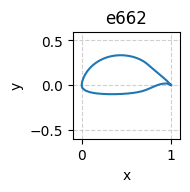

In [6]:
airfoil_dataset.plot(idx=0)

## Implement a VAE (50)

Mostly, the implementation is similar to a plain autoencoder, with the exception that the encoder now gives two outputs $\mu$ and $\sigma$. Usually, the output dimension of the encoder is doubled, and half is used as $\mu$ (`mu`) and the other half is used as $log(\sigma^2)$ (`logvar`). The reason we work with `logvar` is to not worry about the range. $\sigma$ has to be positive, but `logvar` can have any value. To split a tensor into several tensor chunks of the same size along a certain axis, use [`torch.chunk()`](https://pytorch.org/docs/stable/generated/torch.chunk.html).

HINT: to sample from $N(\mu, \sigma^2)$, use [`torch.randn_like()`](https://pytorch.org/docs/stable/generated/torch.randn_like.html) to sample from $N(0,1)$ with the right shape, dtype, and device. Then, think how to turn that into a sample from $N(\mu, \sigma^2)$. This is called the _reparameterization trick_.

In [30]:
class Encoder(nn.Module):
    """
    Probabilistic encoder. Output: mu and logvar of q(z|x).
    """
    def __init__(
            self,
            input_size: int,
            hidden_dims: list,
            latent_size: int,
            ):
        super().__init__()
        # (first half for mu, second half for logvar)
        modules = []
        # Start from input_size -> hidden_dims[0]
        in_features = input_size
        for layer in hidden_dims:
            modules.append(nn.Linear(in_features, layer))
            modules.append(nn.ReLU())  # or another activation, e.g. nn.LeakyReLU()
            in_features = layer

        # So we combine them into a single linear layer of size 2*latent_size
        self.hidden_net = nn.Sequential(*modules)
        self.fc_out = nn.Linear(in_features, 2 * latent_size)

    def forward(
            self, 
            y: torch.FloatTensor, # shape (batch_size, input_size),
            ) -> Tuple[torch.FloatTensor, torch.FloatTensor]: # mu and logvar of q(z|x), both of shape (batch_size, latent_size)
        
        x = self.hidden_net(y)
        x = self.fc_out(x)
        # Split the output into mu and logvar
        mu, logvar = torch.chunk(x, chunks=2, dim=1)
        return mu, logvar
    

class Decoder(nn.Module):
    """
    Treat this as a normal decoder.
    """
    def __init__(
            self,
            latent_size: int,
            hidden_dims: list, # Remember to reverse the Encoder dims
            output_size: int,
            ):
        super().__init__()
        modules = []
        in_features = latent_size
        for hdim in hidden_dims:
            modules.append(nn.Linear(in_features, hdim))
            modules.append(nn.ReLU())
            in_features = hdim
        
        # Final layer to get the reconstruction of size 'output_size'
        self.hidden_net = nn.Sequential(*modules)
        self.fc_out = nn.Linear(in_features, output_size)

    def forward(
            self, 
            z: torch.FloatTensor, # shape (batch_size, latent_size),
            ) -> torch.FloatTensor: # y_hat of shape (batch_size, output_size)
        
        x = self.hidden_net(z)
        y_hat = self.fc_out(x)
        return y_hat
    

class VAE(nn.Module):

    def __init__(
            self,
            input_size: int,
            hidden_dims: list,
            latent_size: int,
            ):
        super().__init__()
        """
        use the encoder and decoder classes you defined above, like:
        self.encoder = Encoder(...)
        self.decoder = Decoder(...)
        """
        self.latent_size = latent_size
        self.encoder = Encoder(input_size, hidden_dims, latent_size)
        self.decoder = Decoder(latent_size, hidden_dims[::-1], output_size=input_size)

    def forward(
            self, 
            y: torch.FloatTensor, # shape (batch_size, input_size),
            ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]: # y_hat, mu, logvar
        """
        - forward pass of the encoder, get mu and logvar
        - sample z from the output of the encoder
        - forward pass of the decoder to get y_hat (reconstruction)
        return y_hat, mu, logvar
        """
        mu, logvar = self.encoder(y)
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # same shape, dtype, device as std
        z = mu + std * eps

        y_hat = self.decoder(z)
        return y_hat, mu, logvar
    
    @torch.inference_mode()
    def generate(
            self,
            n_samples: int,
            seed: int = 0,
            device: str = Device,
            ) -> torch.FloatTensor: # shape (n_samples, input_size)
        
        torch.manual_seed(seed)
        """
        Set the decoder to evaluation mode and move it to the device.
        sample from p(z) with the correct shape and device and dtype
        decode them to generate new samples
        """
        
        self.decoder.eval()
        self.decoder.to(device)

        # Sample z ~ N(0, I)
        z = torch.randn((n_samples, self.latent_size), 
                        device=device)
        
        # Decode to get generated samples
        y_hat = self.decoder(z)
        return y_hat

## Training (10)

In this assigmnent, we are going to use an iteration-based training loop, rather than a primarily epoch-based training loop. This does not impose any significant change, other than how to configure the learning rate scheduler. The learning rate scheduler is now called at every iteration, so you should keep that in mind when defining the hyperpatameters of the scheduler. Fill in the train function where marked by `NotImplemented`.

In [31]:
@torch.enable_grad()
def train_VAE(
        model: VAE,
        train_dataset: AirfoilDataset,
        device = Device,
        plot_freq: int = 100,

        beta: float = 1.,
        rec_loss_fn: nn.Module = nn.MSELoss(),
        optimizer_name: str = 'Adam',
        optimizer_config: dict = dict(),
        lr_scheduler_name: Union[str, None] = None,
        lr_scheduler_config: dict = dict(),
        running_avg_window: int = 20,
        n_iters: int = 1000,
        batch_size: int = 64,
        ):

    assert beta >= 0

    model.train().to(device)

    tracker = VAE_Tracker(
        n_iters = n_iters, 
        plot_freq = plot_freq,
        )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_config)
    if lr_scheduler_name is not None:
        scheduler = lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    iter = 0
    iter_pbar = tqdm(range(n_iters), desc='Iters', unit='iter', leave=True)

    while iter < n_iters:

        for y, name in train_loader:

            y = y.to(device)
            optimizer.zero_grad()
            
            # Implement forward pass and calculate the loss terms
            # Forward pass: get y_hat, mu, logvar from VAE
            y_hat, mu, logvar = model(y)
            rec_loss = rec_loss_fn(y_hat, y)
            prior_loss = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - 1. - logvar, dim=1).mean()
            loss = rec_loss + beta * prior_loss

            loss.backward()
            optimizer.step()

            tracker.update(rec_loss.item(), prior_loss.item(), loss.item())
            running_avg_loss = np.mean(tracker.total_losses[-running_avg_window:])
        
            if lr_scheduler_name == 'ReduceLROnPlateau':
                scheduler.step(running_avg_loss)
            elif lr_scheduler_name is not None:
                scheduler.step()

            iter_pbar.set_postfix_str(f'L_rec: {rec_loss.item():.6f}, L_prior: {prior_loss.item():.6f}, L_total: {loss.item():.6f}')
            iter_pbar.update(1)
            iter += 1
            if iter >= n_iters:
                break

## Find and train a good model (15)

As usual, find a good set of hyperparameters and train your model. However, you have to evaluate your model qualitatively by looking at some generated samples. Run the cell after the training cell to generate 24 samples with the trained model. If almost all your samples are nice and smooth, and diverse, you get 15 points. If they are a bit noisy like the first (leftmost) example, you get 8-12 points, depending on how nonsmooth they are. If your generated samples are nice but all look exactly the same, your model is suffering from mode collapse and you get 5 points. If they are too nonsmooth, like the last example, you get no points.

__Note__: Remember to play with `beta` to see what the effect is on the learning curves and the generated samples. The key to get a nice VAE is to find a nice $\beta$.

__DO NOT CHANGE__ `input_size` and `latent_size`.

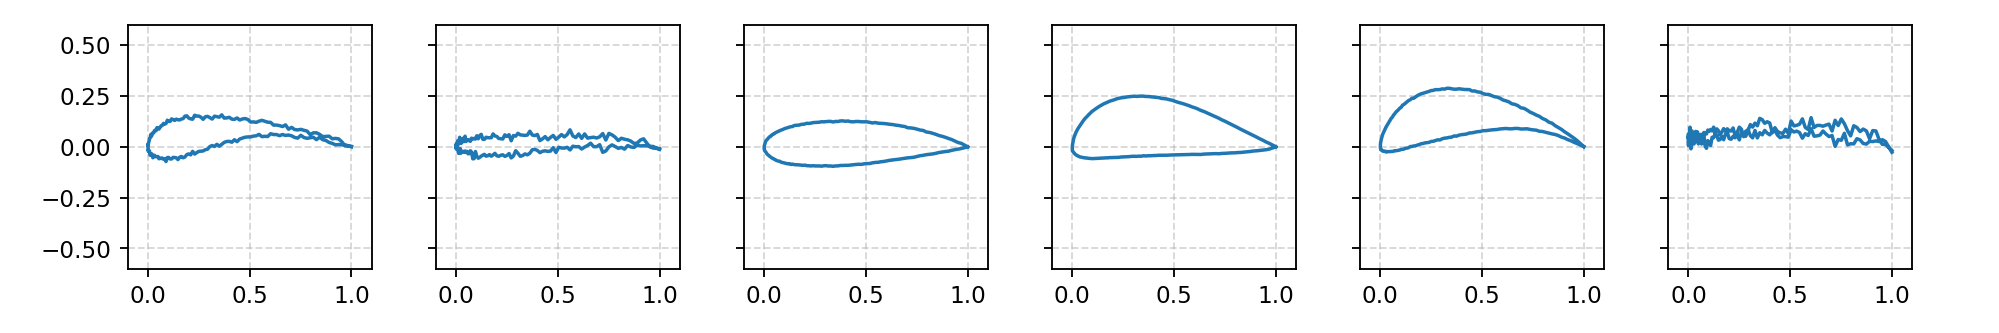

In [99]:
"""
Choose configuration for VAE and train_VAE
"""

model_config = dict(
    input_size = 200,
    hidden_dims = [512,256,128],
    latent_size = 10,
)

train_config = dict(
    beta = 0.00043,
    optimizer_name = "Adam",
    optimizer_config = dict(lr=1e-3),
    lr_scheduler_name = "StepLR",
    lr_scheduler_config = dict(step_size=200, gamma=0.7),
    running_avg_window = 30,
    n_iters = 5000,
    batch_size = 64,
)

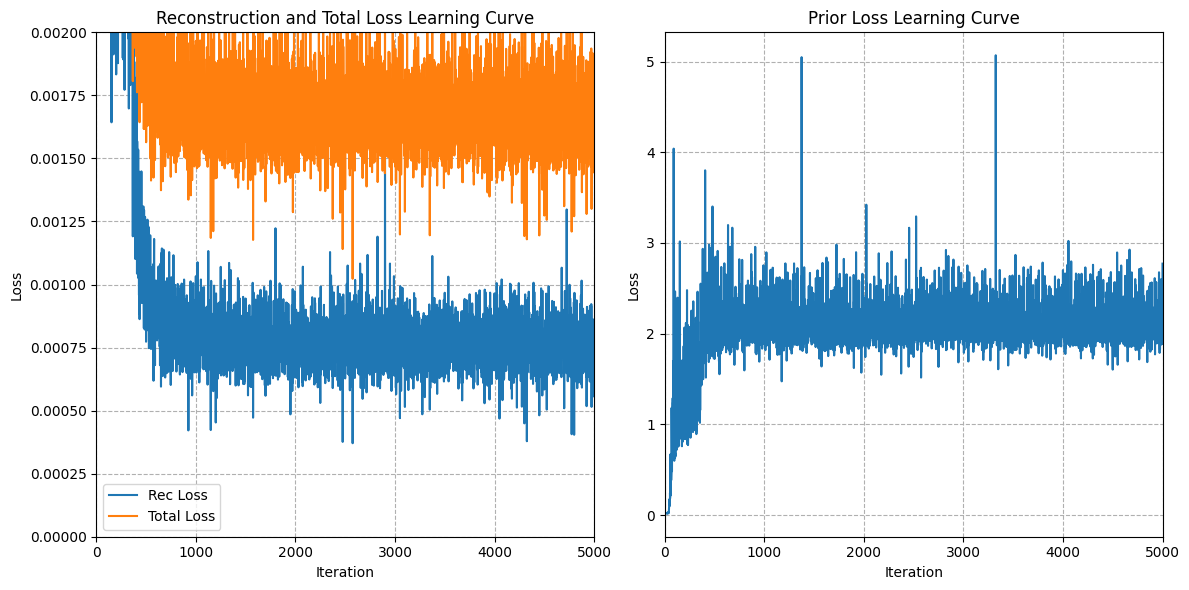

Iters: 100%|██████████| 5000/5000 [01:31<00:00, 54.85iter/s, L_rec: 0.000662, L_prior: 2.772476, L_total: 0.001854]


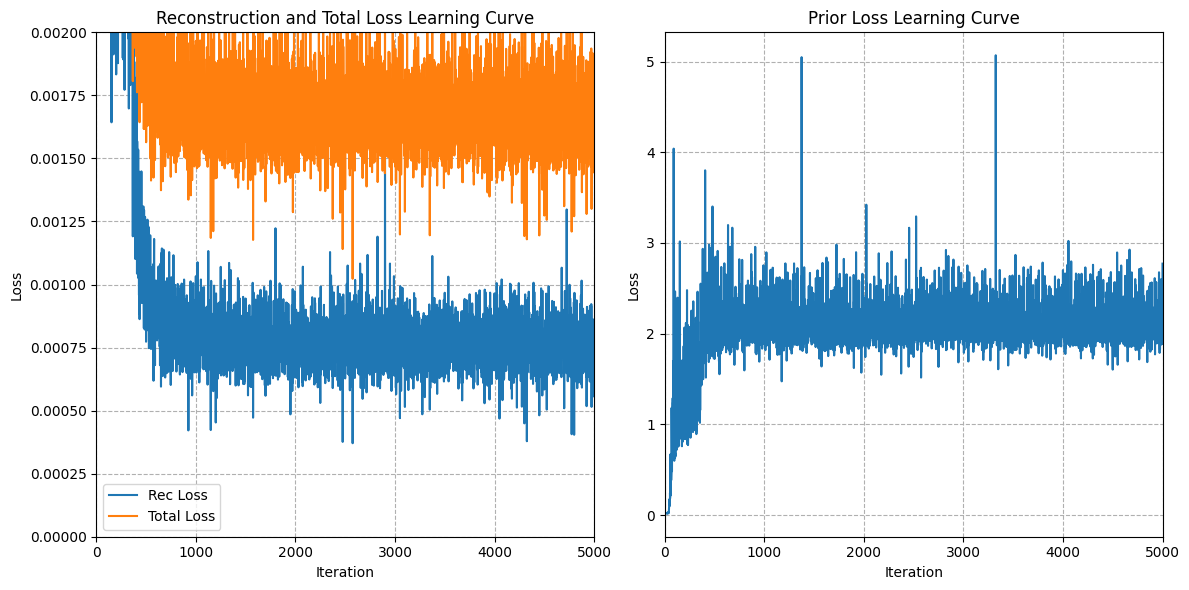

In [100]:
"""
Train the model and monitor the loss terms.
Investigate the effect of beta on the reconstruction and prior loss, and the overall loss.
"""
if __name__ == '__main__':
    airfoil_dataset = AirfoilDataset()
    model = VAE(**model_config)
    train_VAE(
        model = model, 
        train_dataset = airfoil_dataset,
        device = Device,
        plot_freq = 100, # started at 100
        **train_config,
        )

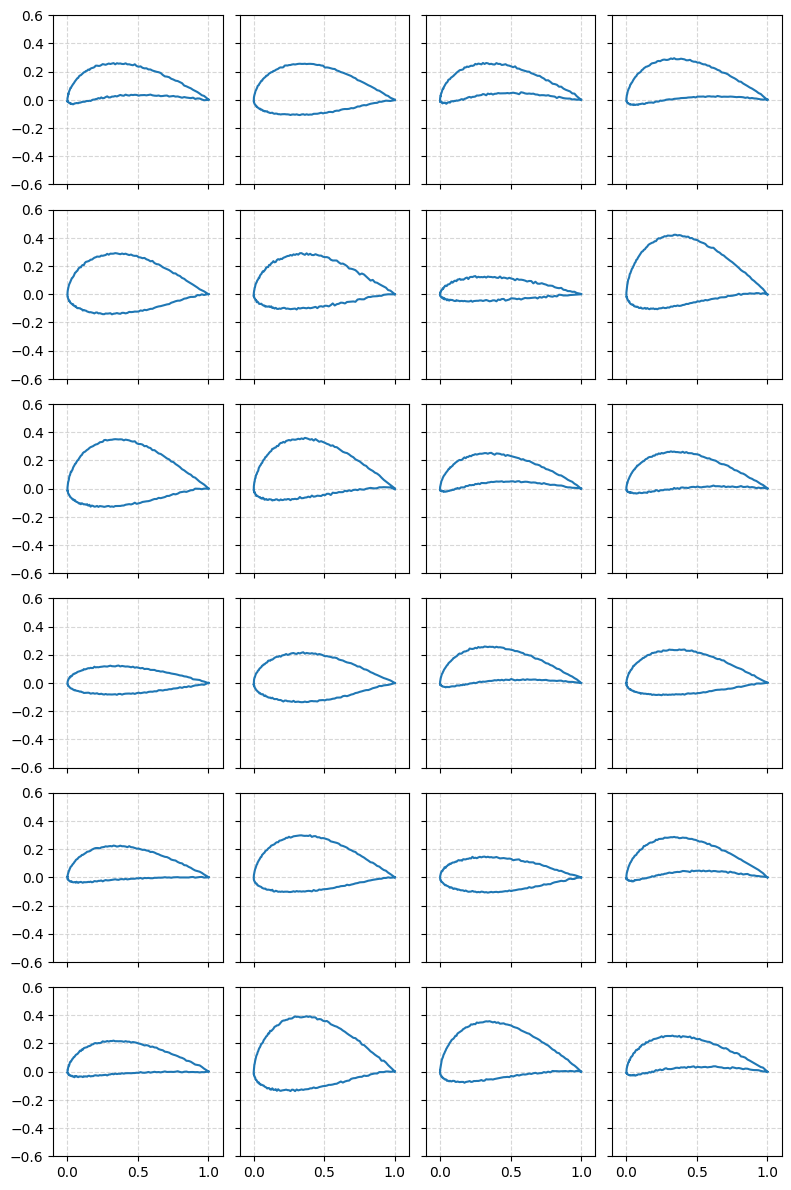

In [101]:
"""
After training, take a look at generated samples.
If you tune beta properly, you should get high quality and diverse generation.
"""
if __name__ == '__main__':
    random_seed = 0 # You can change this, but it may not help you that much. 
    generated_samples = model.generate(n_samples=24, seed=random_seed, device=Device)
    plot_airfoils(airfoil_dataset.get_x(), generated_samples.cpu().numpy())

# Zip submission files

You can run the following cell to zip the generated files for submission.

If you are on Colab, make sure to download and then upload a completed copy of the notebook to the working directory so the code can detect and include it in the zip file for submission.

In [102]:
save_yaml(model_config, 'model_config.yaml')
save_yaml(train_config, 'train_config.yaml')

submission_files = ['HW7.ipynb', 'model_config.yaml', 'train_config.yaml']
zip_files('HW7_submission.zip', submission_files)